In [1]:
import numpy as np
from tqdm import tqdm
import adaptive_latents as al
from adaptive_latents import proSVD, Bubblewrap, SemiRegularizedRegressor, sjPCA
from adaptive_latents.transforms.jpca import apply_sjpca_and_cache
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

In [2]:
individual_identifier = al.input_sources.datasets.individual_identifiers["indy"][0]
psvd_input, regression_output, t, beh_t = al.input_sources.datasets.construct_indy_data(individual_identifier, 0.03)

In [3]:
lower_d = 2
limit = 1000
params = dict(al.default_rwd_parameters, num=100, eps=1e-2)

In [4]:
psvd1 = proSVD(12, centering=True)
jpca_input = psvd1.run_on(psvd_input.T).T

rotated = apply_sjpca_and_cache(input_arr=jpca_input)

data1, regression_output, t = al.transforms.utils.clip(rotated[:,:lower_d], regression_output, t)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/apply_sjpca_and_cache_728412294857201.pickle


In [5]:
in_ds = al.NumpyTimedDataSource(data1, t, time_offsets=(1,))
out_ds = al.NumpyTimedDataSource(regression_output, t, time_offsets=(1,))


bw = al.Bubblewrap(in_ds.output_shape, **params)
reg = al.SemiRegularizedRegressor(input_d=bw.N, output_d=regression_output.shape[1])
br1 = al.BWRun(bw, in_ds, out_ds, behavior_regressor=reg)
br1.run(limit=limit)

1001it [00:15, 64.97it/s]                                                       


In [6]:
psvd2 = proSVD(lower_d, centering=True)
data2 = psvd2.run_on(psvd_input.T).T
data2, regression_output, t = al.transforms.utils.clip(data2, regression_output, t)

In [7]:
in_ds = al.NumpyTimedDataSource(data2, t, time_offsets=(1,))
out_ds = al.NumpyTimedDataSource(regression_output, t, time_offsets=(1,))

bw = al.Bubblewrap(in_ds.output_shape, **params)
reg = al.SemiRegularizedRegressor(input_d=bw.N, output_d=regression_output.shape[1])
br2 = al.BWRun(bw, in_ds, out_ds, behavior_regressor=reg)
br2.run(limit=limit)

1001it [00:08, 116.34it/s]                                                      


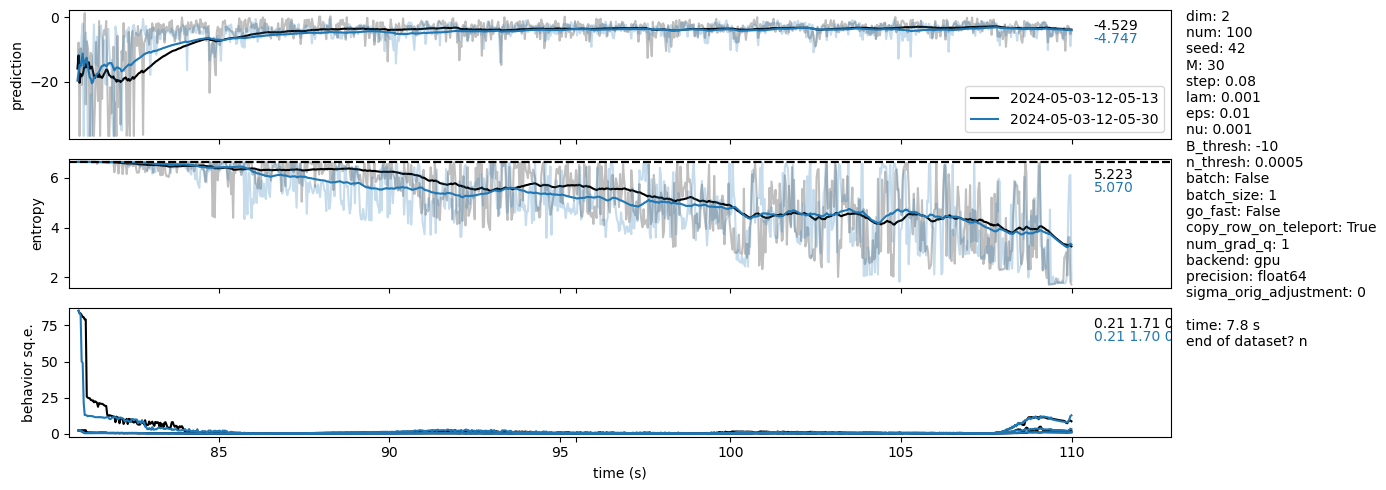

In [9]:
%matplotlib inline
al.plotting_functions.compare_metrics([br1, br2], 1)

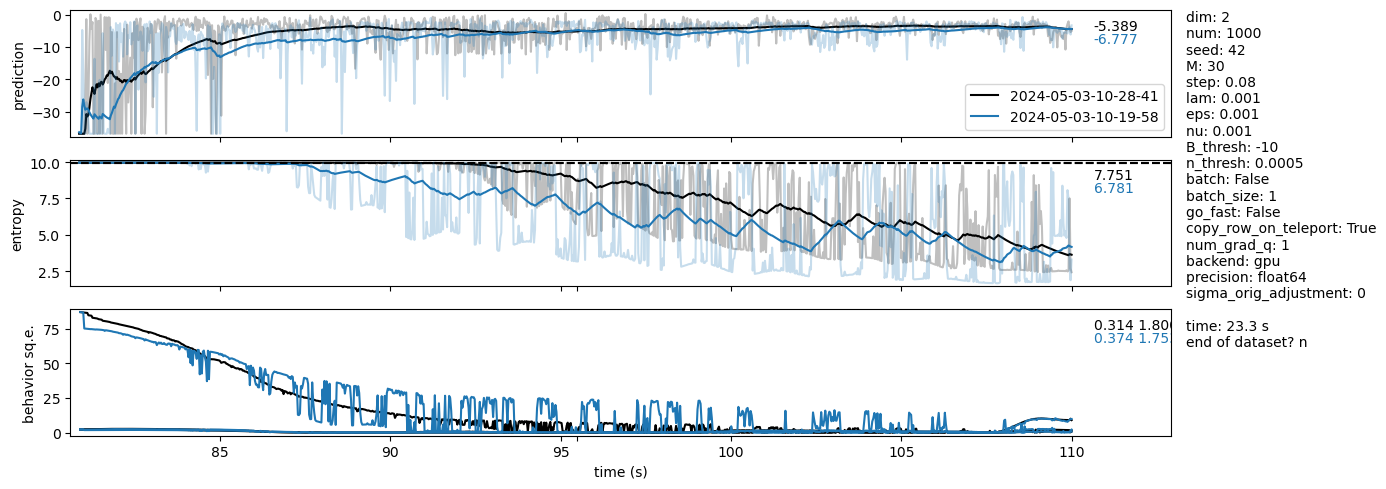

In [11]:
%matplotlib inline
al.plotting_functions.compare_metrics([br1, br2], 1)

compare jpca and prosvd 2d plots